# 👀 多層パーセプトロン (MLP)

In [3]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchinfo | tail -n 1

In [4]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import torchvision
import torch
import torchinfo
import random
from torch import nn
from torch.utils.data import DataLoader
import sys
print(sys.version)
print(torch.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121


In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# シード値を設定
set_seed(123)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cuda


## 0. パラメータ

In [6]:
NUM_CLASSES = 10

## 1. データ準備

In [7]:
# CIFAR10のデータセットを読み込み
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 32
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

CLASSES = np.array([
        "飛行機",
        "自動車",
        "鳥",
        "猫",
        "鹿",
        "犬",
        "カエル",
        "馬",
        "船",
        "トラック"])

100%|██████████| 170M/170M [00:02<00:00, 76.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

(3, 32, 32)


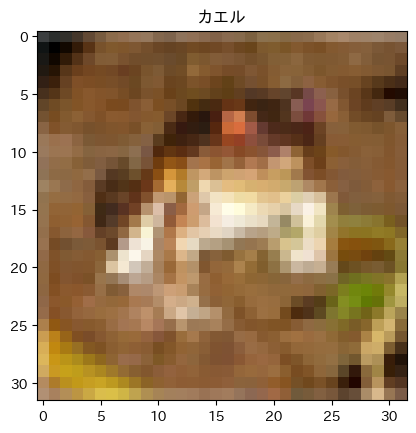

In [8]:
print(trainset)
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
plt.imshow(trainset[0][0].permute(1,2,0))
plt.title(CLASSES[trainset[0][1]])
plt.show()

## 2. モデル構築

In [9]:
class SimpleMLP(nn.Module):
    def __init__(self, num_classes):
        super(SimpleMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 32 * 3, 200)
        self.fc2 = nn.Linear(200, 150)
        self.fc3 = nn.Linear(150, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

In [10]:
model = SimpleMLP(num_classes=NUM_CLASSES)

torchinfo.summary(model.eval(), input_size=(1, 3, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleMLP                                [1, 10]                   --
├─Flatten: 1-1                           [1, 3072]                 --
├─Linear: 1-2                            [1, 200]                  614,600
├─ReLU: 1-3                              [1, 200]                  --
├─Linear: 1-4                            [1, 150]                  30,150
├─ReLU: 1-5                              [1, 150]                  --
├─Linear: 1-6                            [1, 10]                   1,510
├─Softmax: 1-7                           [1, 10]                   --
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
Total mult-adds (M): 0.65
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 2.59
Estimated Total Size (MB): 2.60

## 3. モデルの訓練

In [11]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

In [12]:
epochs = 20
model = model.to(device)
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    count = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # 誤差逆伝播
        loss.backward() # backpropagation
        opt.step() # モデルのパラメータ更新

        running_loss += loss.item() # 誤差の値を加算
        pred = torch.argmax(outputs, dim=1)
        count += torch.sum(pred == labels) # 予測が正しい画像の数を加算

    # epoch終了時点での誤算の平均値，学習データに対する正答率
    print(f'epoch {epoch + 1} loss: {running_loss / len(trainset):.4f} accuracy: {count.item() / len(trainset):.4f}')

epoch 1 loss: 0.0674 accuracy: 0.2957
epoch 2 loss: 0.0657 accuracy: 0.3516
epoch 3 loss: 0.0650 accuracy: 0.3751
epoch 4 loss: 0.0645 accuracy: 0.3898
epoch 5 loss: 0.0642 accuracy: 0.4015
epoch 6 loss: 0.0640 accuracy: 0.4102
epoch 7 loss: 0.0636 accuracy: 0.4194
epoch 8 loss: 0.0634 accuracy: 0.4279
epoch 9 loss: 0.0630 accuracy: 0.4409
epoch 10 loss: 0.0630 accuracy: 0.4408
epoch 11 loss: 0.0627 accuracy: 0.4509
epoch 12 loss: 0.0626 accuracy: 0.4540
epoch 13 loss: 0.0624 accuracy: 0.4608
epoch 14 loss: 0.0622 accuracy: 0.4673
epoch 15 loss: 0.0622 accuracy: 0.4681
epoch 16 loss: 0.0620 accuracy: 0.4752
epoch 17 loss: 0.0619 accuracy: 0.4783
epoch 18 loss: 0.0618 accuracy: 0.4829
epoch 19 loss: 0.0617 accuracy: 0.4844
epoch 20 loss: 0.0615 accuracy: 0.4900


## 4. 評価

In [13]:
CLASSES = np.array([
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck"])

In [15]:
# モデルの評価
model.eval()
count = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        count += torch.sum(preds == labels)

print(f'accuracy: {count.item() / len(testset):.3f}')

accuracy: 0.461


In [18]:
# 最初のバッチの予測値を取得(結果の表示用)
x_test, y_test = next(iter(testloader))
with torch.no_grad():
    preds = model(x_test.to(device)).cpu().detach()
    preds_single = CLASSES[torch.argmax(preds, dim=1)]
    actual_single = CLASSES[y_test]

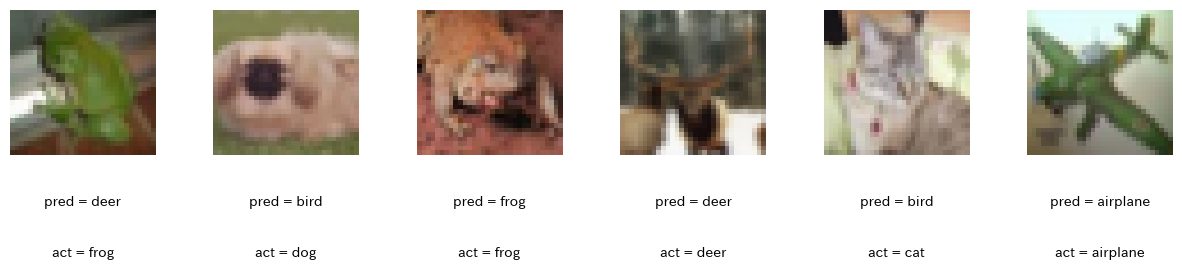

In [19]:
n_to_show = 6
indices = np.random.choice(range(batch_size), n_to_show, replace=False)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = next(iter(testloader))[0][idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img.permute(1, 2, 0))